In [1]:
%load_ext autoreload
%autoreload 2

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib import cm

from scipy.stats import mode
from sklearn.manifold import TSNE
from sklearn.cluster import MiniBatchKMeans
from scipy.stats import pearsonr as corr
from sklearn.manifold import TSNE

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

global_seed = 20230831

from main_cifar10 import *

Using device: cuda
Using device: cuda
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/home/cool_klindt/anaconda3/envs/pytorch/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/cool_klindt/anaconda3/envs/pytorch/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /home/cool_klindt/PerceptualSimilarity/lpips/weights/v0.1/alex.pth


In [2]:
log_dir = 'results/test4/'
with open(os.path.join(log_dir, 'results.pkl'), 'rb') as f:
    results = pickle.load(f)

results['layer1'].keys()

dict_keys(['output_shape', 'activations', 'activations_normed', 'kmeans_num_dic', 'kmeans_128', 'kmeans_128dist', 'kmeans_256', 'kmeans_256dist', 'kmeans_512', 'kmeans_512dist', 'data_train', 'data_test', 'data_train_kmeans_128', 'data_test_kmeans_128', 'data_train_kmeans_256', 'data_test_kmeans_256', 'data_train_kmeans_512', 'data_test_kmeans_512', 'probabilities', 'probabilities_kmeans_128', 'probabilities_kmeans_256', 'probabilities_kmeans_512', 'monosemanticity', 'monosemanticity_kmeans_128', 'monosemanticity_kmeans_256', 'monosemanticity_kmeans_512', 'kmeans_128_top', 'kmeans_128_topdist', 'data_train_kmeans_128_top', 'data_test_kmeans_128_top', 'monosemanticity_kmeans_128_top', 'kmeans_128_bottom', 'kmeans_128_bottomdist', 'data_train_kmeans_128_bottom', 'data_test_kmeans_128_bottom', 'monosemanticity_kmeans_128_bottom', 'kmeans_256_top', 'kmeans_256_topdist', 'data_train_kmeans_256_top', 'data_test_kmeans_256_top', 'monosemanticity_kmeans_256_top', 'kmeans_256_bottom', 'kmeans_2

In [3]:
def get_mei_data(activations, inputs, k=10):
    "Get most activating images as train and test for psychophysics"
    num_unit = activations.shape[1]
    data_top = np.zeros((num_unit, k, 3, 32, 32))
    data_bottom = np.zeros((num_unit, k, 3, 32, 32))
    for i in range(num_unit):
        y = activations[:, i].copy()
        ind_sort = np.argsort(y)[::-1]
        data_top[i] = inputs[ind_sort[:k]].copy()
        data_bottom[i] = inputs[ind_sort[-k:]].copy()
    return data_top, data_bottom

In [4]:
data_top, data_bottom = get_mei_data(
    results['layer1']['activations'], 
    results['inputs'], 
    k=10
)
data_top.shape, data_bottom.shape

((256, 10, 3, 32, 32), (256, 10, 3, 32, 32))

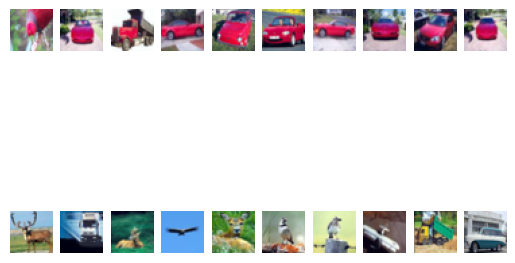

In [6]:
ind = np.argmin(results['layer1']['monosemanticity'])
for i in range(10):
    plt.subplot(2, 10, i + 1)
    imshow(data_top[ind, i])
    plt.subplot(2, 10, i + 11)
    imshow(data_bottom[ind, i])
plt.show()

In [16]:
np.random.seed(42)
ind_test = np.random.randint((10, ))
ind_train = np.arange(10) != ind_test

data_top_train = data_top[ind, ind_train].copy()
data_top_test = data_top[ind, ind_test].copy()
data_bottom_train = data_bottom[ind, ind_train].copy()
data_bottom_test = data_bottom[ind, ind_test].copy()

In [19]:
print(lpips_metric(data_top_train, data_top_test).min())
print(lpips_metric(data_top_train, data_bottom_test).min())
print(lpips_metric(data_bottom_train, data_top_test).min())
print(lpips_metric(data_bottom_train, data_bottom_test).min())

0.0279515
0.3212945
0.24130765
0.1316632


In [20]:
pool_fun = np.min
logit = np.zeros((2, 2))
# choose top
logit[0, 0] = pool_fun(lpips_metric(data_top_train, data_top_test)) # evidence from top
logit[0, 1] = pool_fun(lpips_metric(data_bottom_train, data_bottom_test)) # evidence from bottom
# choose bottom
logit[1, 0] = pool_fun(lpips_metric(data_top_train, data_bottom_test)) # evidence from top
logit[1, 1] = pool_fun(lpips_metric(data_bottom_train, data_top_test)) # evidence from bottom
logit

array([[0.0279515 , 0.1316632 ],
       [0.32129449, 0.24130765]])

In [24]:
logits = np.zeros((10, 2, 2))
for i in range(10):
    ind_test = np.array((i, ))
    ind_train = np.arange(10) != ind_test

    data_top_train = data_top[ind, ind_train].copy()
    data_top_test = data_top[ind, ind_test].copy()
    data_bottom_train = data_bottom[ind, ind_train].copy()
    data_bottom_test = data_bottom[ind, ind_test].copy()

    # choose top
    logits[i, 0, 0] = pool_fun(lpips_metric(data_top_train, data_top_test)) # evidence from top
    logits[i, 0, 1] = pool_fun(lpips_metric(data_bottom_train, data_bottom_test)) # evidence from bottom
    # choose bottom
    logits[i, 1, 0] = pool_fun(lpips_metric(data_top_train, data_bottom_test)) # evidence from top
    logits[i, 1, 1] = pool_fun(lpips_metric(data_bottom_train, data_top_test)) # evidence from bottom
    
    

In [27]:
logits.argmin(1)

array([[0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0]])

In [31]:
ind = 0

logits = np.zeros((10, 2, 2))
for i in range(10):
    ind_test = np.array((i, ))
    ind_train = np.arange(10) != ind_test

    data_top_train = data_top[ind, ind_train].copy()
    data_top_test = data_top[ind, ind_test].copy()
    data_bottom_train = data_bottom[ind, ind_train].copy()
    data_bottom_test = data_bottom[ind, ind_test].copy()

    # choose top
    logits[i, 0, 0] = pool_fun(lpips_metric(data_top_train, data_top_test)) # evidence from top
    logits[i, 0, 1] = pool_fun(lpips_metric(data_bottom_train, data_bottom_test)) # evidence from bottom
    # choose bottom
    logits[i, 1, 0] = pool_fun(lpips_metric(data_top_train, data_bottom_test)) # evidence from top
    logits[i, 1, 1] = pool_fun(lpips_metric(data_bottom_train, data_top_test)) # evidence from bottom

print(logits.argmin(1))
print(logits.sum(2).argmin(1))
    

[[0 1]
 [0 1]
 [0 0]
 [0 1]
 [0 1]
 [0 1]
 [0 0]
 [1 0]
 [0 0]
 [1 0]]
[0 0 0 1 0 0 0 0 0 0]


# adding the evidences seems to work better

In [32]:
# all neurons
logits = np.zeros((256, 10, 2, 2))
for ind in range(256):
    print(ind)
    for i in range(10):
        ind_test = np.array((i, ))
        ind_train = np.arange(10) != ind_test

        data_top_train = data_top[ind, ind_train].copy()
        data_top_test = data_top[ind, ind_test].copy()
        data_bottom_train = data_bottom[ind, ind_train].copy()
        data_bottom_test = data_bottom[ind, ind_test].copy()

        # choose top
        logits[ind, i, 0, 0] = pool_fun(lpips_metric(data_top_train, data_top_test)) # evidence from top
        logits[ind, i, 0, 1] = pool_fun(lpips_metric(data_bottom_train, data_bottom_test)) # evidence from bottom
        # choose bottom
        logits[ind, i, 1, 0] = pool_fun(lpips_metric(data_top_train, data_bottom_test)) # evidence from top
        logits[ind, i, 1, 1] = pool_fun(lpips_metric(data_bottom_train, data_top_test)) # evidence from bottom
    

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255


In [41]:
print('separate', np.mean(logits.argmin(2)))
print('add evidence', np.mean(logits.sum(3).argmin(2)))
print('only top', np.mean(logits[:, :, :, 0].argmin(2)))
print('only bottom', np.mean(logits[:, :, :, 1].argmin(2)))

separate 0.3521484375
add evidence 0.259375
only top 0.290234375
only bottom 0.4140625


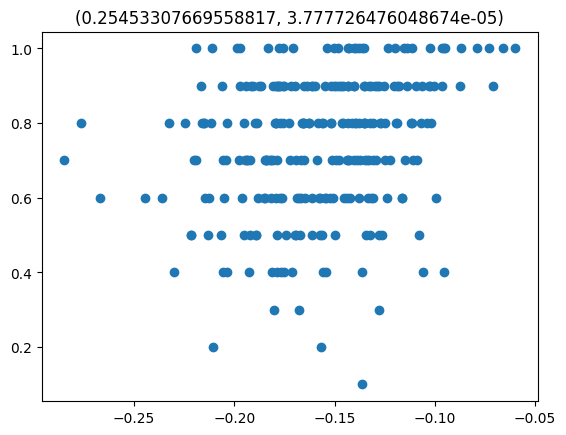

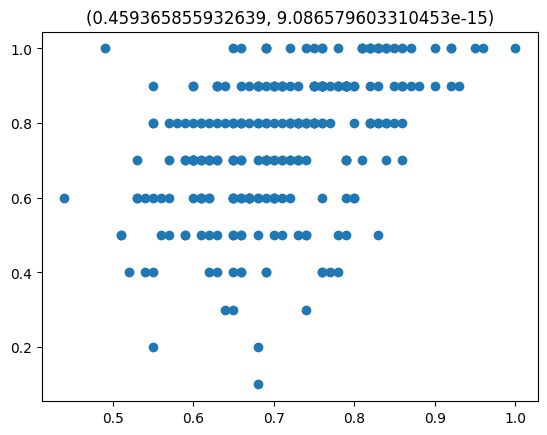

In [42]:
plt.scatter(
    -results['layer1']['monosemanticity'],
    1 - logits.sum(3).argmin(2).mean(1)
)
plt.title(corr(
    -results['layer1']['monosemanticity'],
    1 - logits.sum(3).argmin(2).mean(1)
))
plt.show()

plt.scatter(
    results['layer1']['psychophysics_acc'],
    1 - logits.sum(3).argmin(2).mean(1)
)
plt.title(corr(
    results['layer1']['psychophysics_acc'],
    1 - logits.sum(3).argmin(2).mean(1)
))
plt.show()

In [43]:
# kmeans
data_top, data_bottom = get_mei_data(
    -results['layer1']['kmeans_256dist'], 
    results['inputs'], 
    k=10
)
logits_kmeans = np.zeros((256, 10, 2, 2))
for ind in range(256):
    print(ind)
    for i in range(10):
        ind_test = np.array((i, ))
        ind_train = np.arange(10) != ind_test

        data_top_train = data_top[ind, ind_train].copy()
        data_top_test = data_top[ind, ind_test].copy()
        data_bottom_train = data_bottom[ind, ind_train].copy()
        data_bottom_test = data_bottom[ind, ind_test].copy()

        # choose top
        logits_kmeans[ind, i, 0, 0] = pool_fun(lpips_metric(data_top_train, data_top_test)) # evidence from top
        logits_kmeans[ind, i, 0, 1] = pool_fun(lpips_metric(data_bottom_train, data_bottom_test)) # evidence from bottom
        # choose bottom
        logits_kmeans[ind, i, 1, 0] = pool_fun(lpips_metric(data_top_train, data_bottom_test)) # evidence from top
        logits_kmeans[ind, i, 1, 1] = pool_fun(lpips_metric(data_bottom_train, data_top_test)) # evidence from bottom

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255


{'whiskers': [<matplotlib.lines.Line2D at 0x7f7bc61e3ac0>,
 'caps': [<matplotlib.lines.Line2D at 0x7f7bc61e1720>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f7bc61e2e30>,
 'medians': [<matplotlib.lines.Line2D at 0x7f7bc61e1e40>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f7bc61e19c0>,
 'means': []}

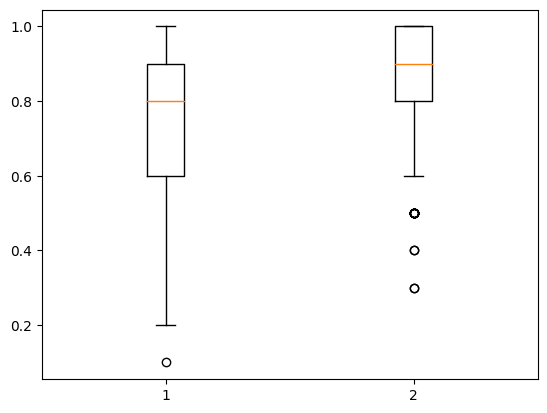

In [44]:
plt.boxplot([
    1 - logits.sum(3).argmin(2).mean(1),
    1 - logits_kmeans.sum(3).argmin(2).mean(1)
])

# Other Metrics

In [66]:
def color_metric(a, b):
    color_a = np.mean(a, (2, 3))
    color_b = np.mean(b, (2, 3))
    dist = np.sum((color_a[:, None] - color_b[None]) ** 2, axis=2)
    return np.sqrt(dist)

#color_metric(data_top_train, data_top_test)

In [53]:
def get_label_data(activations, label, k=10):
    "Get label as train and test for psychophysics"
    num_unit = activations.shape[1]
    data_top = np.zeros((num_unit, k))
    data_bottom = np.zeros((num_unit, k))
    for i in range(num_unit):
        y = activations[:, i].copy()
        ind_sort = np.argsort(y)[::-1]
        data_top[i] = label[ind_sort[:k]].copy()
        data_bottom[i] = label[ind_sort[-k:]].copy()
    return data_top, data_bottom

data_top, data_bottom = get_label_data(
    -results['layer1']['kmeans_256dist'], 
    results['labels'], 
    k=10
)

def label_metric(a, b):
    return a == b


label_metric(data_top[0], data_bottom[0, :1])

array([ True, False, False,  True,  True, False, False, False,  True,
       False])

In [54]:
data_top[0], data_bottom[0, :1]

(array([5., 6., 4., 5., 5., 4., 3., 6., 5., 3.]), array([5.]))

In [64]:
# Layer 1
data_top, data_bottom = get_mei_data(
    results['layer1']['activations'], 
    results['inputs'], 
    k=10
)
label_top, label_bottom = get_label_data(
    results['layer1']['activations'], 
    results['labels'], 
    k=10
)

logits_lpips = np.zeros((256, 10, 2, 2))
logits_color = np.zeros((256, 10, 2, 2))
logits_label = np.zeros((256, 10, 2, 2))
for ind in range(256):
    print(ind)
    for i in range(10):
        ind_test = np.array((i, ))
        ind_train = np.arange(10) != ind_test

        data_top_train = data_top[ind, ind_train].copy()
        data_top_test = data_top[ind, ind_test].copy()
        data_bottom_train = data_bottom[ind, ind_train].copy()
        data_bottom_test = data_bottom[ind, ind_test].copy()

        # lpips
        pool_fun = np.mean
        # choose top
        logits_lpips[ind, i, 0, 0] = pool_fun(lpips_metric(data_top_train, data_top_test)) # evidence from top
        logits_lpips[ind, i, 0, 1] = pool_fun(lpips_metric(data_bottom_train, data_bottom_test)) # evidence from bottom
        # choose bottom
        logits_lpips[ind, i, 1, 0] = pool_fun(lpips_metric(data_top_train, data_bottom_test)) # evidence from top
        logits_lpips[ind, i, 1, 1] = pool_fun(lpips_metric(data_bottom_train, data_top_test)) # evidence from bottom

        # color
        # choose top
        logits_color[ind, i, 0, 0] = pool_fun(color_metric(data_top_train, data_top_test)) # evidence from top
        logits_color[ind, i, 0, 1] = pool_fun(color_metric(data_bottom_train, data_bottom_test)) # evidence from bottom
        # choose bottom
        logits_color[ind, i, 1, 0] = pool_fun(color_metric(data_top_train, data_bottom_test)) # evidence from top
        logits_color[ind, i, 1, 1] = pool_fun(color_metric(data_bottom_train, data_top_test)) # evidence from bottom

        # label
        pool_fun = np.mean
        data_top_train = label_top[ind, ind_train].copy()
        data_top_test = label_top[ind, ind_test].copy()
        data_bottom_train = label_bottom[ind, ind_train].copy()
        data_bottom_test = label_bottom[ind, ind_test].copy()
        # choose top
        logits_label[ind, i, 0, 0] = pool_fun(label_metric(data_top_train, data_top_test)) # evidence from top
        logits_label[ind, i, 0, 1] = pool_fun(label_metric(data_bottom_train, data_bottom_test)) # evidence from bottom
        # choose bottom
        logits_label[ind, i, 1, 0] = pool_fun(label_metric(data_top_train, data_bottom_test)) # evidence from top
        logits_label[ind, i, 1, 1] = pool_fun(label_metric(data_bottom_train, data_top_test)) # evidence from bottom


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255


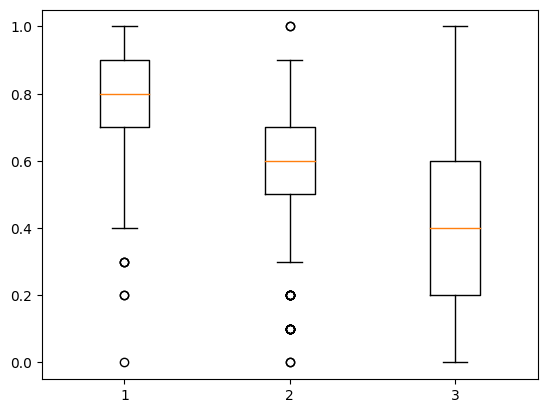

In [61]:
plt.boxplot([
    1 - logits_lpips.sum(3).argmin(2).mean(1),
    1 - logits_color.sum(3).argmin(2).mean(1),
    1 - logits_label.sum(3).argmin(2).mean(1),
])
plt.show()

In [68]:
# Layer 2
data_top, data_bottom = get_mei_data(
    results['layer2']['activations'], 
    results['inputs'], 
    k=10
)
label_top, label_bottom = get_label_data(
    results['layer2']['activations'], 
    results['labels'], 
    k=10
)
num_neuron = results['layer2']['activations'].shape[1]

logits2_lpips = np.zeros((num_neuron, 10, 2, 2))
logits2_color = np.zeros((num_neuron, 10, 2, 2))
logits2_label = np.zeros((num_neuron, 10, 2, 2))
for ind in range(num_neuron):
    if not ind % 10:
        print(ind, num_neuron)
    for i in range(10):
        ind_test = np.array((i, ))
        ind_train = np.arange(10) != ind_test

        data_top_train = data_top[ind, ind_train].copy()
        data_top_test = data_top[ind, ind_test].copy()
        data_bottom_train = data_bottom[ind, ind_train].copy()
        data_bottom_test = data_bottom[ind, ind_test].copy()

        # lpips
        pool_fun = np.mean
        # choose top
        logits2_lpips[ind, i, 0, 0] = pool_fun(lpips_metric(data_top_train, data_top_test)) # evidence from top
        logits2_lpips[ind, i, 0, 1] = pool_fun(lpips_metric(data_bottom_train, data_bottom_test)) # evidence from bottom
        # choose bottom
        logits2_lpips[ind, i, 1, 0] = pool_fun(lpips_metric(data_top_train, data_bottom_test)) # evidence from top
        logits2_lpips[ind, i, 1, 1] = pool_fun(lpips_metric(data_bottom_train, data_top_test)) # evidence from bottom

        # color
        # choose top
        logits2_color[ind, i, 0, 0] = pool_fun(color_metric(data_top_train, data_top_test)) # evidence from top
        logits2_color[ind, i, 0, 1] = pool_fun(color_metric(data_bottom_train, data_bottom_test)) # evidence from bottom
        # choose bottom
        logits2_color[ind, i, 1, 0] = pool_fun(color_metric(data_top_train, data_bottom_test)) # evidence from top
        logits2_color[ind, i, 1, 1] = pool_fun(color_metric(data_bottom_train, data_top_test)) # evidence from bottom

        # label
        pool_fun = np.mean
        data_top_train = label_top[ind, ind_train].copy()
        data_top_test = label_top[ind, ind_test].copy()
        data_bottom_train = label_bottom[ind, ind_train].copy()
        data_bottom_test = label_bottom[ind, ind_test].copy()
        # choose top
        logits2_label[ind, i, 0, 0] = pool_fun(label_metric(data_top_train, data_top_test)) # evidence from top
        logits2_label[ind, i, 0, 1] = pool_fun(label_metric(data_bottom_train, data_bottom_test)) # evidence from bottom
        # choose bottom
        logits2_label[ind, i, 1, 0] = pool_fun(label_metric(data_top_train, data_bottom_test)) # evidence from top
        logits2_label[ind, i, 1, 1] = pool_fun(label_metric(data_bottom_train, data_top_test)) # evidence from bottom


0 512
10 512
20 512
30 512
40 512
50 512
60 512
70 512
80 512
90 512
100 512
110 512
120 512
130 512
140 512
150 512
160 512
170 512
180 512
190 512
200 512
210 512
220 512
230 512
240 512
250 512
260 512
270 512
280 512
290 512
300 512
310 512
320 512
330 512
340 512
350 512
360 512
370 512
380 512
390 512
400 512
410 512
420 512
430 512
440 512
450 512
460 512
470 512
480 512
490 512
500 512
510 512


In [71]:
# Layer 3
#num_neuron = results['layer3']['activations'].shape[1]
num_neuron = 256
data_top, data_bottom = get_mei_data(
    results['layer3']['activations'][:, :num_neuron], 
    results['inputs'], 
    k=10
)
label_top, label_bottom = get_label_data(
    results['layer3']['activations'][:, :num_neuron], 
    results['labels'], 
    k=10
)

logits3_lpips = np.zeros((num_neuron, 10, 2, 2))
logits3_color = np.zeros((num_neuron, 10, 2, 2))
logits3_label = np.zeros((num_neuron, 10, 2, 2))
for ind in range(num_neuron):
    if not ind % 10:
        print(ind, num_neuron)
    for i in range(10):
        ind_test = np.array((i, ))
        ind_train = np.arange(10) != ind_test

        data_top_train = data_top[ind, ind_train].copy()
        data_top_test = data_top[ind, ind_test].copy()
        data_bottom_train = data_bottom[ind, ind_train].copy()
        data_bottom_test = data_bottom[ind, ind_test].copy()

        # lpips
        pool_fun = np.mean
        # choose top
        logits3_lpips[ind, i, 0, 0] = pool_fun(lpips_metric(data_top_train, data_top_test)) # evidence from top
        logits3_lpips[ind, i, 0, 1] = pool_fun(lpips_metric(data_bottom_train, data_bottom_test)) # evidence from bottom
        # choose bottom
        logits3_lpips[ind, i, 1, 0] = pool_fun(lpips_metric(data_top_train, data_bottom_test)) # evidence from top
        logits3_lpips[ind, i, 1, 1] = pool_fun(lpips_metric(data_bottom_train, data_top_test)) # evidence from bottom

        # color
        # choose top
        logits3_color[ind, i, 0, 0] = pool_fun(color_metric(data_top_train, data_top_test)) # evidence from top
        logits3_color[ind, i, 0, 1] = pool_fun(color_metric(data_bottom_train, data_bottom_test)) # evidence from bottom
        # choose bottom
        logits3_color[ind, i, 1, 0] = pool_fun(color_metric(data_top_train, data_bottom_test)) # evidence from top
        logits3_color[ind, i, 1, 1] = pool_fun(color_metric(data_bottom_train, data_top_test)) # evidence from bottom

        # label
        pool_fun = np.mean
        data_top_train = label_top[ind, ind_train].copy()
        data_top_test = label_top[ind, ind_test].copy()
        data_bottom_train = label_bottom[ind, ind_train].copy()
        data_bottom_test = label_bottom[ind, ind_test].copy()
        # choose top
        logits3_label[ind, i, 0, 0] = pool_fun(label_metric(data_top_train, data_top_test)) # evidence from top
        logits3_label[ind, i, 0, 1] = pool_fun(label_metric(data_bottom_train, data_bottom_test)) # evidence from bottom
        # choose bottom
        logits3_label[ind, i, 1, 0] = pool_fun(label_metric(data_top_train, data_bottom_test)) # evidence from top
        logits3_label[ind, i, 1, 1] = pool_fun(label_metric(data_bottom_train, data_top_test)) # evidence from bottom


0 256
10 256
20 256
30 256
40 256
50 256
60 256
70 256
80 256
90 256
100 256
110 256
120 256
130 256
140 256
150 256
160 256
170 256
180 256
190 256
200 256
210 256
220 256
230 256
240 256
250 256


In [76]:
# Layer 4
#num_neuron = results['layer4']['activations'].shape[1]
num_neuron = 256
data_top, data_bottom = get_mei_data(
    results['layer4']['activations'][:, :num_neuron], 
    results['inputs'], 
    k=10
)
label_top, label_bottom = get_label_data(
    results['layer4']['activations'][:, :num_neuron], 
    results['labels'], 
    k=10
)

logits4_lpips = np.zeros((num_neuron, 10, 2, 2))
logits4_color = np.zeros((num_neuron, 10, 2, 2))
logits4_label = np.zeros((num_neuron, 10, 2, 2))
for ind in range(num_neuron):
    if not ind % 10:
        print(ind, num_neuron)
    for i in range(10):
        ind_test = np.array((i, ))
        ind_train = np.arange(10) != ind_test

        data_top_train = data_top[ind, ind_train].copy()
        data_top_test = data_top[ind, ind_test].copy()
        data_bottom_train = data_bottom[ind, ind_train].copy()
        data_bottom_test = data_bottom[ind, ind_test].copy()

        # lpips
        pool_fun = np.mean
        # choose top
        logits4_lpips[ind, i, 0, 0] = pool_fun(lpips_metric(data_top_train, data_top_test)) # evidence from top
        logits4_lpips[ind, i, 0, 1] = pool_fun(lpips_metric(data_bottom_train, data_bottom_test)) # evidence from bottom
        # choose bottom
        logits4_lpips[ind, i, 1, 0] = pool_fun(lpips_metric(data_top_train, data_bottom_test)) # evidence from top
        logits4_lpips[ind, i, 1, 1] = pool_fun(lpips_metric(data_bottom_train, data_top_test)) # evidence from bottom

        # color
        # choose top
        logits4_color[ind, i, 0, 0] = pool_fun(color_metric(data_top_train, data_top_test)) # evidence from top
        logits4_color[ind, i, 0, 1] = pool_fun(color_metric(data_bottom_train, data_bottom_test)) # evidence from bottom
        # choose bottom
        logits4_color[ind, i, 1, 0] = pool_fun(color_metric(data_top_train, data_bottom_test)) # evidence from top
        logits4_color[ind, i, 1, 1] = pool_fun(color_metric(data_bottom_train, data_top_test)) # evidence from bottom

        # label
        pool_fun = np.mean
        data_top_train = label_top[ind, ind_train].copy()
        data_top_test = label_top[ind, ind_test].copy()
        data_bottom_train = label_bottom[ind, ind_train].copy()
        data_bottom_test = label_bottom[ind, ind_test].copy()
        # choose top
        logits4_label[ind, i, 0, 0] = pool_fun(label_metric(data_top_train, data_top_test)) # evidence from top
        logits4_label[ind, i, 0, 1] = pool_fun(label_metric(data_bottom_train, data_bottom_test)) # evidence from bottom
        # choose bottom
        logits4_label[ind, i, 1, 0] = pool_fun(label_metric(data_top_train, data_bottom_test)) # evidence from top
        logits4_label[ind, i, 1, 1] = pool_fun(label_metric(data_bottom_train, data_top_test)) # evidence from bottom


0 256
10 256
20 256
30 256
40 256
50 256
60 256
70 256
80 256
90 256
100 256
110 256
120 256
130 256
140 256
150 256
160 256
170 256
180 256
190 256
200 256
210 256
220 256
230 256
240 256
250 256


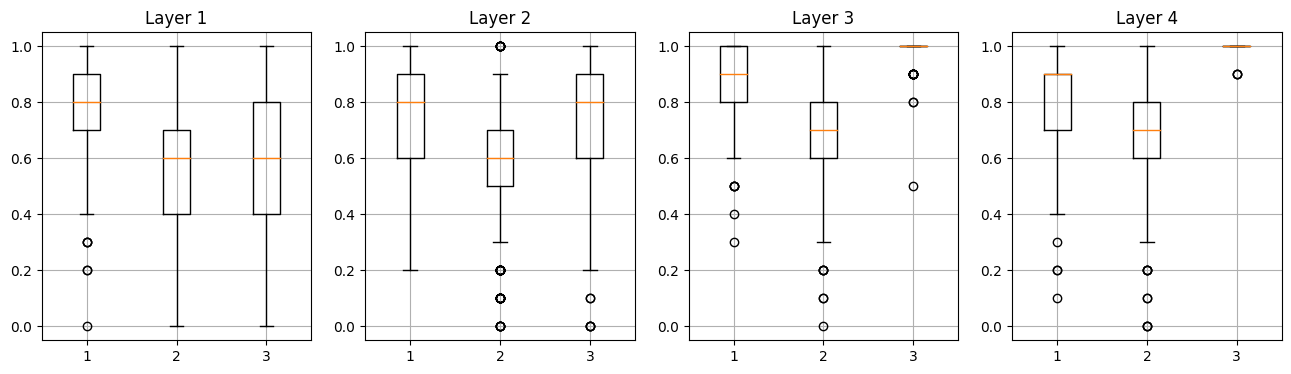

In [77]:
plt.figure(figsize=(16, 4))
plt.subplot(1, 4, 1)
plt.boxplot([
    1 - logits_lpips.sum(3).argmin(2).mean(1),
    1 - logits_color.sum(3).argmin(2).mean(1),
    logits_label.sum(3).argmin(2).mean(1),
])
plt.title('Layer 1')
plt.grid()

plt.subplot(1, 4, 2)
plt.boxplot([
    1 - logits2_lpips.sum(3).argmin(2).mean(1),
    1 - logits2_color.sum(3).argmin(2).mean(1),
    logits2_label.sum(3).argmin(2).mean(1),
])
plt.title('Layer 2')
plt.grid()

plt.subplot(1, 4, 3)
plt.boxplot([
    1 - logits3_lpips.sum(3).argmin(2).mean(1),
    1 - logits3_color.sum(3).argmin(2).mean(1),
    logits3_label.sum(3).argmin(2).mean(1),
])
plt.title('Layer 3')
plt.grid()

plt.subplot(1, 4, 4)
plt.boxplot([
    1 - logits4_lpips.sum(3).argmin(2).mean(1),
    1 - logits4_color.sum(3).argmin(2).mean(1),
    logits4_label.sum(3).argmin(2).mean(1),
])
plt.title('Layer 4')
plt.grid()

plt.show()

In [80]:
num_neuron = 256
pool_fun = np.mean
#logits = np.zeros((4, 2, 3, num_neuron, 10, 2, 2))

for l in range(1, 4):
    layer = 'layer%s' % (l + 1)
    for k, key in enumerate(['activations', 'kmeans_%sdist']):
        if k == 1:
            key = key % results[layer]['activations'].shape[1]
        data_top, data_bottom = get_mei_data(
            results[layer][key][:, :num_neuron], 
            results['inputs'], 
            k=10
        )
        label_top, label_bottom = get_label_data(
            results[layer][key][:, :num_neuron], 
            results['labels'], 
            k=10
        )
        
        for ind in range(num_neuron):
            if not ind % 100:
                print(
                    'layer', layer,
                     'key', key,
                    'neuron', ind, num_neuron)
            for i in range(10):
                ind_test = np.array((i, ))
                ind_train = np.arange(10) != ind_test

                data_top_train = data_top[ind, ind_train].copy()
                data_top_test = data_top[ind, ind_test].copy()
                data_bottom_train = data_bottom[ind, ind_train].copy()
                data_bottom_test = data_bottom[ind, ind_test].copy()

                # lpips
                # choose top
                logits[l, k, 0, ind, i, 0, 0] = pool_fun(lpips_metric(data_top_train, data_top_test)) # evidence from top
                logits[l, k, 0, ind, i, 0, 1] = pool_fun(lpips_metric(data_bottom_train, data_bottom_test)) # evidence from bottom
                # choose bottom
                logits[l, k, 0, ind, i, 1, 0] = pool_fun(lpips_metric(data_top_train, data_bottom_test)) # evidence from top
                logits[l, k, 0, ind, i, 1, 1] = pool_fun(lpips_metric(data_bottom_train, data_top_test)) # evidence from bottom

                # color
                # choose top
                logits[l, k, 1, ind, i, 0, 0] = pool_fun(color_metric(data_top_train, data_top_test)) # evidence from top
                logits[l, k, 1, ind, i, 0, 1] = pool_fun(color_metric(data_bottom_train, data_bottom_test)) # evidence from bottom
                # choose bottom
                logits[l, k, 1, ind, i, 1, 0] = pool_fun(color_metric(data_top_train, data_bottom_test)) # evidence from top
                logits[l, k, 1, ind, i, 1, 1] = pool_fun(color_metric(data_bottom_train, data_top_test)) # evidence from bottom

                # label
                data_top_train = label_top[ind, ind_train].copy()
                data_top_test = label_top[ind, ind_test].copy()
                data_bottom_train = label_bottom[ind, ind_train].copy()
                data_bottom_test = label_bottom[ind, ind_test].copy()
                # choose top
                logits[l, k, 2, ind, i, 0, 0] = pool_fun(label_metric(data_top_train, data_top_test)) # evidence from top
                logits[l, k, 2, ind, i, 0, 1] = pool_fun(label_metric(data_bottom_train, data_bottom_test)) # evidence from bottom
                # choose bottom
                logits[l, k, 2, ind, i, 1, 0] = pool_fun(label_metric(data_top_train, data_bottom_test)) # evidence from top
                logits[l, k, 2, ind, i, 1, 1] = pool_fun(label_metric(data_bottom_train, data_top_test)) # evidence from bottom


layer 1 key activations neuron 0 256
layer 1 key activations neuron 100 256
layer 1 key activations neuron 200 256
layer 1 key kmeans_512dist neuron 0 256
layer 1 key kmeans_512dist neuron 100 256
layer 1 key kmeans_512dist neuron 200 256
layer 2 key activations neuron 0 256
layer 2 key activations neuron 100 256
layer 2 key activations neuron 200 256
layer 2 key kmeans_1024dist neuron 0 256
layer 2 key kmeans_1024dist neuron 100 256
layer 2 key kmeans_1024dist neuron 200 256
layer 3 key activations neuron 0 256
layer 3 key activations neuron 100 256
layer 3 key activations neuron 200 256
layer 3 key kmeans_2048dist neuron 0 256
layer 3 key kmeans_2048dist neuron 100 256
layer 3 key kmeans_2048dist neuron 200 256


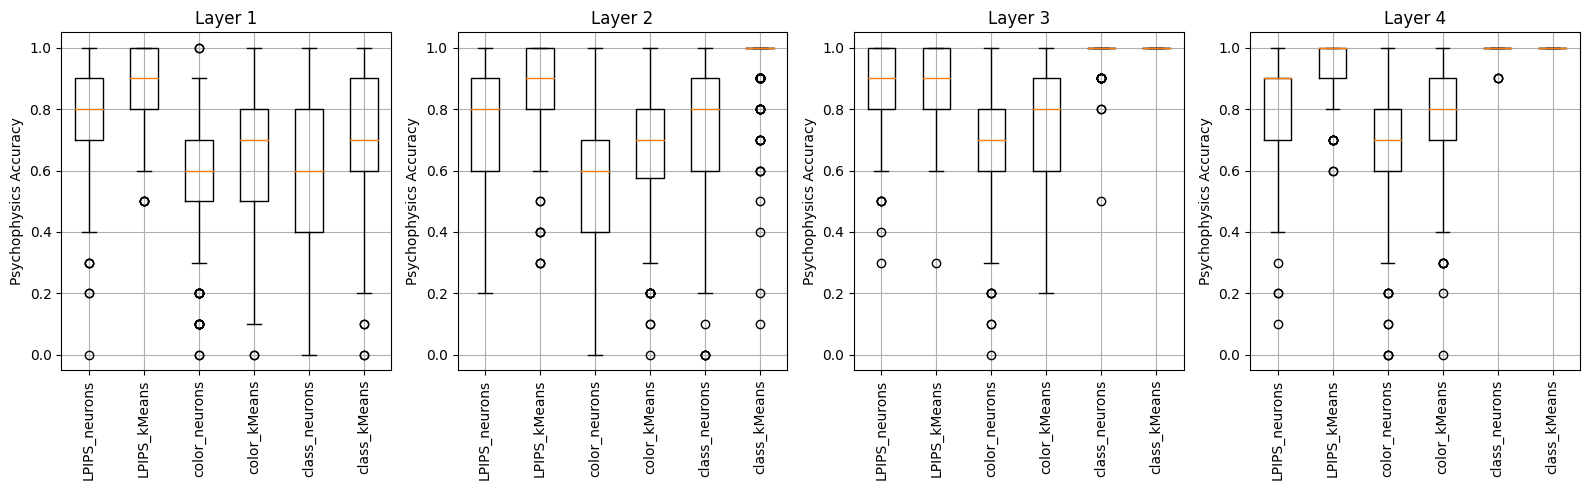

In [86]:
#logits = np.zeros((4, 2, 3, num_neuron, 10, 2, 2))

plt.figure(figsize=(16, 5))
for l in range(4):
    plt.subplot(1, 4, 1 + l)
    plt.boxplot([
        1 - logits[l, 0, 0].sum(3).argmin(2).mean(1),
        1 - logits[l, 1, 0].sum(3).argmin(2).mean(1),
        1 - logits[l, 0, 1].sum(3).argmin(2).mean(1),
        1 - logits[l, 1, 1].sum(3).argmin(2).mean(1),
        logits[l, 0, 2].sum(3).argmin(2).mean(1),
        logits[l, 1, 2].sum(3).argmin(2).mean(1),
    ])
    plt.title('Layer %s' % (l + 1))
    plt.grid()
    plt.xticks(
        np.arange(1, 7),
        [
            'LPIPS_neurons',
            'LPIPS_kMeans',
            'color_neurons',
            'color_kMeans',
            'class_neurons',
            'class_kMeans',
        ],
        rotation=90
    )
    plt.ylabel('Psychophysics Accuracy')
plt.tight_layout()
plt.show()